Welcome All, below I intend to demonstrate the simulated implementation of one of the most famous trading strategies on the open bitcoin dataset kindly shared here. I will flag up some of the many gotchas in this type of simulation. The strategy is attributed to Richard Dennis and his team of "turtle" traders, check out the book "Way of the Turtle" for more details.

Note I would strongly recommend that you not actually trade this, this is purely a simple example to highlight various tricks and pitfalls with the data. This kernel does not consitute trading or financial advice in anyway. Bitcoin is a particularly volatile market with some unique challenges and not the place to start in my limited opinion if you are interested in algorithmic trading.

This is a work in progress, please comment if you'd like to see more and I will extend it for the execution simulation

In [1]:
import datetime
import matplotlib.pyplot as plt
import numpy as np 
import os
import pandas as pd 

%matplotlib inline

#define a conversion function for the native timestamps in the csv file
def dateparse(time_in_secs):    
    return datetime.datetime.fromtimestamp(float(time_in_secs))

from subprocess import check_output
print('\n'.join(os.listdir('./input')))

bitstampUSD_1-min_data_2012-01-01_to_2017-10-20
bitstampUSD_1-min_data_2012-01-01_to_2017-10-20.tail1000
btceUSD_1-min_data_2012-01-01_to_2017-05-31.csv
btcnCNY_1-min_data_2012-01-01_to_2017-05-31.csv
coinbaseUSD_1-min_data_2014-12-01_to_2017-10-20.csv.csv
coincheckJPY_1-min_data_2014-10-31_to_2017-10-20.csv
krakenEUR_1-min_data_2014-01-08_to_2017-05-31.csv
krakenUSD_1-min_data_2014-01-07_to_2017-05-31.csv


In [2]:
# read in the data and apply our conversion function, this spits out a 
# DataFrame with the DateTimeIndex already in place
df = pd.read_csv('./input/bitstampUSD_1-min_data_2012-01-01_to_2017-10-20', 
                   parse_dates=True, date_parser=dateparse, index_col=[0])
df.describe()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
count,3.045857e+06,3.045857e+06,3.045857e+06,3.045857e+06,3.045857e+06,3.045857e+06,3.045857e+06
mean,5.892415e+02,5.896265e+02,5.888079e+02,5.892375e+02,1.112631e+01,5.522198e+03,5.892079e+02
std,8.829786e+02,8.836372e+02,8.821788e+02,8.829554e+02,3.638031e+01,2.490013e+04,8.828978e+02
min,3.800000e+00,3.800000e+00,1.500000e+00,1.500000e+00,0.000000e+00,0.000000e+00,3.800000e+00
25%,1.013700e+02,1.015200e+02,1.011700e+02,1.014500e+02,4.224604e-01,6.206358e+01,1.013800e+02
50%,3.625000e+02,3.627500e+02,3.622200e+02,3.625000e+02,2.002134e+00,3.194455e+02,3.624715e+02
75%,6.319900e+02,6.322100e+02,6.316200e+02,6.319900e+02,8.658260e+00,2.111275e+03,6.319714e+02
max,5.846430e+03,5.846430e+03,5.839640e+03,5.844400e+03,5.853852e+03,4.339350e+06,5.845752e+03


In [3]:
df.tail()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
Timestamp,,,,,,,
2017-10-20 07:56:00,5690.88,5690.88,5690.88,5690.88,0.168941,961.421706,5690.880000
2017-10-20 07:57:00,5698.13,5704.10,5695.63,5704.10,2.311662,13174.852877,5699.300163
2017-10-20 07:58:00,5695.62,5695.64,5694.00,5695.64,0.129647,738.409647,5695.533637
2017-10-20 07:59:00,5700.39,5700.39,5698.69,5698.69,0.085426,486.929798,5700.004031
2017-10-20 08:00:00,5700.00,5700.00,5698.68,5700.00,0.116847,665.913860,5699.046463


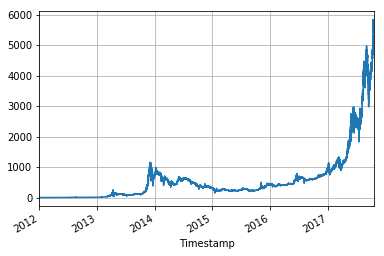

In [4]:
# Weighted_Price随时间变化关系
df['Weighted_Price'].plot(grid=True)

In [5]:
# First thing is to fix the data for bars/candles where there are no trades. 
# Volume/trades are a single event so fill na's with zeroes for relevant fields...
df['Volume_(BTC)'].fillna(value=0, inplace=True)
df['Volume_(Currency)'].fillna(value=0, inplace=True)
df['Weighted_Price'].fillna(value=0, inplace=True)

# next we need to fix the OHLC (open high low close) data which is a continuous timeseries so
# lets fill forwards those values...
df['Open'].fillna(method='ffill', inplace=True)
df['High'].fillna(method='ffill', inplace=True)
df['Low'].fillna(method='ffill', inplace=True)
df['Close'].fillna(method='ffill', inplace=True)

# check how we are looking now, should be nice and clean...
df.tail()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
Timestamp,,,,,,,
2017-10-20 07:56:00,5690.88,5690.88,5690.88,5690.88,0.168941,961.421706,5690.880000
2017-10-20 07:57:00,5698.13,5704.10,5695.63,5704.10,2.311662,13174.852877,5699.300163
2017-10-20 07:58:00,5695.62,5695.64,5694.00,5695.64,0.129647,738.409647,5695.533637
2017-10-20 07:59:00,5700.39,5700.39,5698.69,5698.69,0.085426,486.929798,5700.004031
2017-10-20 08:00:00,5700.00,5700.00,5698.68,5700.00,0.116847,665.913860,5699.046463


In [6]:
df.dtypes

Open                 float64
High                 float64
Low                  float64
Close                float64
Volume_(BTC)         float64
Volume_(Currency)    float64
Weighted_Price       float64
dtype: object

In [7]:
df.shape

(3045857, 7)

In [10]:
# 取最近一年数据
df = df[(df.index >= '2016-10-20') & (df.index < '2017-10-20')]
df.shape

(525600, 7)

In [11]:
# 将分钟级数据转化成天级数据
from __future__ import division

#h_data = data.resample('1D', how={'ohlc'})
daily_df = pd.DataFrame()
daily_df['Open'] = df['Open'].resample('1D').first()
daily_df['High'] = df['High'].resample('1D').max()
daily_df['Low'] = df['Low'].resample('1D').min()
daily_df['Close'] = df['Close'].resample('1D').last()
daily_df['Volume_(BTC)'] = df['Volume_(BTC)'].resample('1D').sum()
daily_df['Volume_(Currency)'] = df['Volume_(Currency)'].resample('1D').sum()
daily_df['Weighted_Price'] = daily_df['Volume_(Currency)'] / daily_df['Volume_(BTC)']

print(daily_df.tail())
print(daily_df.shape)

               Open     High      Low    Close  Volume_(BTC)  \
Timestamp                                                      
2017-10-15  5702.39  5830.00  5415.00  5520.14  11088.152514   
2017-10-16  5534.16  5747.97  5452.95  5699.95   8673.942481   
2017-10-17  5699.92  5807.11  5506.78  5584.96  10707.480608   
2017-10-18  5584.00  5639.90  5101.36  5324.07  15789.898096   
2017-10-19  5324.07  5735.00  5320.12  5640.04  12711.506490   

            Volume_(Currency)  Weighted_Price  
Timestamp                                      
2017-10-15       6.237185e+07     5625.089723  
2017-10-16       4.878521e+07     5624.340638  
2017-10-17       6.045576e+07     5646.123583  
2017-10-18       8.469727e+07     5364.016328  
2017-10-19       7.068754e+07     5560.909859  
(365, 7)


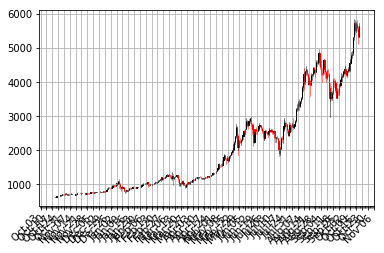

In [20]:
from matplotlib.dates import DateFormatter, WeekdayLocator, DayLocator, MONDAY, date2num
from matplotlib.finance import candlestick_ohlc

def pandas_candlestick_ohlc(dat, stick = "day", otherseries = None):
    mondays = WeekdayLocator(MONDAY)    # major ticks on the mondays
    alldays = DayLocator()              # minor ticks on the days
    dayFormatter = DateFormatter('%d')      # e.g., 12
 
    # Create a new DataFrame which includes OHLC data for each period specified by stick input
    transdat = dat.loc[:,["Open", "High", "Low", "Close"]]
    if (type(stick) == str):
        if stick == "day":
            plotdat = transdat
            stick = 1 # Used for plotting
        elif stick in ["week", "month", "year"]:
            if stick == "week":
                transdat["week"] = pd.to_datetime(transdat.index).map(
                    lambda x: x.isocalendar()[1]) # Identify weeks
            elif stick == "month":
                transdat["month"] = pd.to_datetime(transdat.index).map(
                    lambda x: x.month) # Identify months
            else:
                transdat["year"] = pd.to_datetime(transdat.index).map(
                    lambda x: x.isocalendar()[0]) # Identify years
            # Group by year and other appropriate variable
            grouped = transdat.groupby(list(set(["year",stick]))) 
            plotdat = pd.DataFrame({"Open": [], "High": [], "Low": [], "Close": []}) # Create empty data frame containing what will be plotted
            for name, group in grouped:
                plotdat = plotdat.append(pd.DataFrame({"Open": group.iloc[0,0],
                                            "High": max(group.High),
                                            "Low": min(group.Low),
                                            "Close": group.iloc[-1,3]},
                                           index = [group.index[0]]))
            if stick == "week": stick = 5
            elif stick == "month": stick = 30
            elif stick == "year": stick = 365
 
    elif (type(stick) == int and stick >= 1):
        transdat["stick"] = [np.floor(i / stick) for i in range(len(transdat.index))]
        grouped = transdat.groupby("stick")
        plotdat = pd.DataFrame({"Open": [], "High": [], "Low": [], "Close": []}) # Create empty data frame containing what will be plotted
        for name, group in grouped:
            plotdat = plotdat.append(pd.DataFrame({"Open": group.iloc[0,0],
                                        "High": max(group.High),
                                        "Low": min(group.Low),
                                        "Close": group.iloc[-1,3]},
                                       index = [group.index[0]]))
 
    else:
        raise ValueError('Valid inputs to argument "stick" include the strings "day", "week", "month", "year", or a positive integer')
 
 
    # Set plot parameters, including the axis object ax used for plotting
    fig, ax = plt.subplots()
    fig.subplots_adjust(bottom=0.2)
    if plotdat.index[-1] - plotdat.index[0]< pd.Timedelta('730 days'):
        weekFormatter = DateFormatter('%b %d')  # e.g., Jan 12
        ax.xaxis.set_major_locator(mondays)
        ax.xaxis.set_minor_locator(alldays)
    else:
        weekFormatter = DateFormatter('%b %d, %Y')
    ax.xaxis.set_major_formatter(weekFormatter)
 
    ax.grid(True)
 
    # Create the candelstick chart
    candlestick_ohlc(ax, list(zip(list(date2num(plotdat.index.tolist())), 
            plotdat["Open"].tolist(), plotdat["High"].tolist(),
            plotdat["Low"].tolist(), plotdat["Close"].tolist())),
            colorup = "black", colordown = "red", width = stick * .4)
 
    # Plot other series (such as moving averages) as lines
    if otherseries != None:
        if type(otherseries) != list:
            otherseries = [otherseries]
        dat.loc[:,otherseries].plot(ax = ax, lw = 1.3, grid = True)
 
    ax.xaxis_date()
    ax.autoscale_view()
    plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
 
    plt.show()
 
pandas_candlestick_ohlc(daily_df)

In [12]:
# 以收盘价计算的单日投资回报
yesterday_close_price = daily_df['Close'].shift(1)
today_close_price = daily_df['Close']
daily_df['return_d0'] = (today_close_price - yesterday_close_price)/yesterday_close_price
daily_df.tail()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,return_d0
Timestamp,,,,,,,,
2017-10-15,5702.39,5830.00,5415.00,5520.14,11088.152514,6.237185e+07,5625.089723,-0.030016
2017-10-16,5534.16,5747.97,5452.95,5699.95,8673.942481,4.878521e+07,5624.340638,0.032573
2017-10-17,5699.92,5807.11,5506.78,5584.96,10707.480608,6.045576e+07,5646.123583,-0.020174
2017-10-18,5584.00,5639.90,5101.36,5324.07,15789.898096,8.469727e+07,5364.016328,-0.046713
2017-10-19,5324.07,5735.00,5320.12,5640.04,12711.506490,7.068754e+07,5560.909859,0.059347


In [13]:
# 以单日收盘价来设定目标变量
daily_df['return_target'] = np.where(daily_df['return_d0'] > 0, 1, 0)
daily_df.tail()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,return_d0,return_target
Timestamp,,,,,,,,,
2017-10-15,5702.39,5830.00,5415.00,5520.14,11088.152514,6.237185e+07,5625.089723,-0.030016,0
2017-10-16,5534.16,5747.97,5452.95,5699.95,8673.942481,4.878521e+07,5624.340638,0.032573,1
2017-10-17,5699.92,5807.11,5506.78,5584.96,10707.480608,6.045576e+07,5646.123583,-0.020174,0
2017-10-18,5584.00,5639.90,5101.36,5324.07,15789.898096,8.469727e+07,5364.016328,-0.046713,0
2017-10-19,5324.07,5735.00,5320.12,5640.04,12711.506490,7.068754e+07,5560.909859,0.059347,1


In [33]:
# The first thing we need are our trading signals. The Turtle strategy was based on daily data and
# they used to enter breakouts (new higher highs or new lower lows) in the 22-60 day range roughly.
# We are dealing with minute bars here so a 22 minute new high isn't much to get excited about. Lets
# pick an equivalent to 60 days then. They also only considered Close price so lets do the same...

# signal_lookback = 60 * 24 * 60 # days * hours * minutes
signal_lookback = 60 # days

# here's our signal columns
daily_df['Buy'] = np.zeros(len(daily_df))
daily_df['Sell'] = np.zeros(len(daily_df))

# this is our 'working out', you could collapse these into the .loc call later on and save memory 
# but I've left them in for debug purposes, makes it easier to see what is going on
daily_df['RollingMax'] = daily_df['Close'].shift(1).rolling(signal_lookback, min_periods=signal_lookback).max()
daily_df['RollingMin'] = daily_df['Close'].shift(1).rolling(signal_lookback, min_periods=signal_lookback).min()
daily_df.loc[daily_df['RollingMax'] < daily_df['Close'], 'Buy'] = 1
daily_df.loc[daily_df['RollingMin'] > daily_df['Close'], 'Sell'] = -1
daily_df.tail()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,return_d0,return_target,Buy,Sell,RollingMax,RollingMin
Timestamp,,,,,,,,,,,,,
2017-10-15,5702.39,5830.00,5415.00,5520.14,11088.152514,6.237185e+07,5625.089723,-0.030016,0,0.0,0.0,5721.0,3520.0
2017-10-16,5534.16,5747.97,5452.95,5699.95,8673.942481,4.878521e+07,5624.340638,0.032573,1,0.0,0.0,5721.0,3520.0
2017-10-17,5699.92,5807.11,5506.78,5584.96,10707.480608,6.045576e+07,5646.123583,-0.020174,0,0.0,0.0,5721.0,3520.0
2017-10-18,5584.00,5639.90,5101.36,5324.07,15789.898096,8.469727e+07,5364.016328,-0.046713,0,0.0,0.0,5721.0,3520.0
2017-10-19,5324.07,5735.00,5320.12,5640.04,12711.506490,7.068754e+07,5560.909859,0.059347,1,0.0,0.0,5721.0,3520.0


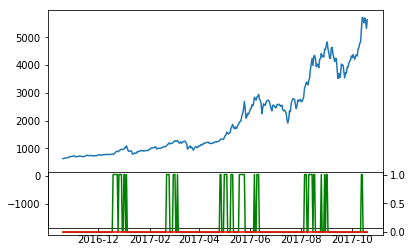

In [34]:
# lets now take a look and see if its doing something sensible
import matplotlib
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(1,1)
ax1.plot(daily_df['Close'])
y = ax1.get_ylim()
ax1.set_ylim(y[0] - (y[1]-y[0])*0.4, y[1])

ax2 = ax1.twinx()
ax2.set_position(matplotlib.transforms.Bbox([[0.125,0.1],[0.9,0.32]]))
ax2.plot(daily_df['Buy'], color='g')
ax2.plot(daily_df['Sell'], color='r')

In [36]:
df.index[0]

Timestamp('2016-10-20 00:00:00')

In [60]:
#绘制K线图, from: https://www.joinquant.com/post/726
import time
import datetime
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.dates as mdates
from matplotlib.finance import candlestick_ohlc
import matplotlib
#import pylab
#import talib

def plotKLine(df, tech):
    fig = plt.figure(figsize=(20, 10))
    x = 0
    y = len(df.Close)
    date = np.linspace(0, y, y)
    candle_array = []
    while x < y:
        day = df.index[x]
        appendLine = day, df.Open[day], df.Close[day], df.High[day], df.Close[day], df['Volume_(BTC)'][day], df['Volume_(Currency)'][day]
        candle_array.append(appendLine)
        x += 1
    
    ax1 = plt.subplot2grid((10,4), (0,0), rowspan=5, colspan=4)
    candlestick_ohlc(ax1, candle_array, width=1, colorup='r', colordown='g')

    ax1.plot(df.index, tech['tenkan_sen'],'r')
    ax1.plot(df.index, tech['kijun_sen'],'b')
    ax1.plot(df.index, tech['senkou_A'],'k')
    ax1.plot(df.index, tech['senkou_B'],'k')
    ax1.fill_between(df.index, tech['senkou_A'], tech['senkou_B'], alpha=0.5, facecolor= 'y', edgecolor='y')
    ax1.plot(date, tech['chikou'],'g')
    
    ax2 = plt.subplot2grid((10,4),(5,0), rowspan=2, colspan=4, sharex=ax1)
    barlist = ax2.bar(df.index, df['Volume_(BTC)'])
    for day in range(len(df.index)):
            if df.Open[day] < df.Close[day]:
                barlist[day].set_color('r')
            else:
                barlist[day].set_color('g')

In [61]:
def getIchimoku(df):
    openp, highp, lowp, closep = df.Open, df.High, df.Low, df.Close
    
    n = len(openp)
    
    tenkan_sen = np.empty(n)
    tenkan_sen[:] = np.NAN
    for i in range(9, n):
        minP = min(lowp[i-9:i])
        maxP = max(highp[i-9:i])
        tenkan_sen[i] = (minP+maxP)/2.0

    kijun_sen = np.empty(n)
    kijun_sen[:] = np.NAN
    for i in range(26,n):
        minP = min(lowp[i-26:i])
        maxP = max(highp[i-26:i])
        kijun_sen[i] = (minP+maxP)/2.0

    senkou_A = np.empty(n)
    senkou_A[:] = np.NAN
    for i in range(52,n-26):
        senkou_A[i+26] = (kijun_sen[i]+tenkan_sen[i])/2.0

    senkou_B = np.empty(n)
    senkou_B[:] = np.NAN
    for i in range(52,n-26):
        minP = min(lowp[i-52:i])
        maxP = max(highp[i-52:i])
        senkou_B[i+26] = (minP+maxP)/2.0

    chikou = np.empty(n)
    chikou[:] = np.NAN
    for i in range(26,n):
        chikou[i-26] = closep[i]

    return tenkan_sen, kijun_sen, senkou_A, senkou_B, chikou

TypeError: unsupported operand type(s) for -: 'Timestamp' and 'float'

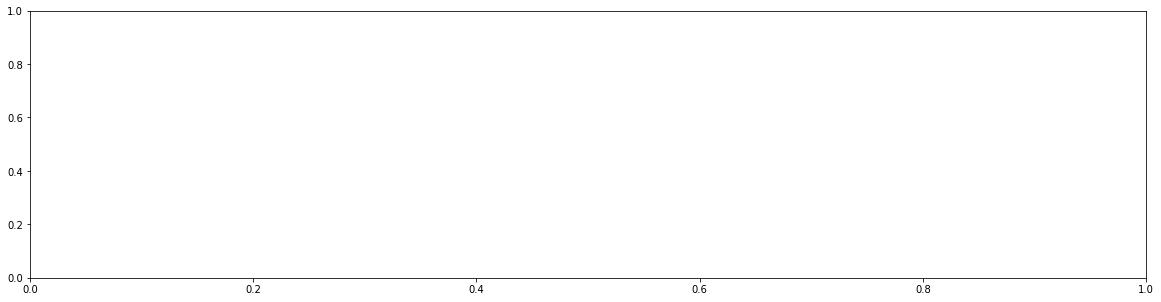

In [62]:
tech = {}
tech['tenkan_sen'], tech['kijun_sen'], tech['senkou_A'], tech['senkou_B'], tech['chikou'] = getIchimoku(daily_df)
plotKLine(daily_df, tech)